In [1]:
# from utils import * 

import os
os.chdir("../../scVI/")
os.getcwd()

import pickle
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
import gseapy as gp
save_path = '../CSF/Notebooks/'
from copy import deepcopy

In [2]:
celllabels = np.load(save_path + 'meta/celllabels.npy')
celltypes, labels = np.unique(celllabels,return_inverse=True)
isCSF = np.load(save_path + 'meta/isCSF.npy')
isMS = np.load(save_path + 'meta/isMS.npy')
genenames = pd.read_csv('../CSF/RFiles/genenames.csv',header=None)


In [3]:
# celltypes
# clean = [1,2,3,4,5,6,7,8,10,11,13,14,17,18,19,20,21]
# with open(save_path + 'DE/MSinCSF.DEres.pkl', 'rb') as f:
#     tissueDE,tissueDEclust = pickle.load(f)

# temp=[x in clean for x in tissueDEclust]
# tissueDE = [tissueDE[i] for i,x in enumerate(temp) if x is True]
# tissueDEclust = [tissueDEclust[i] for i,x in enumerate(temp) if x is True]

In [4]:
print(celltypes[tissueDEclust])
print("total %i cell types"%len(tissueDE))

NameError: name 'tissueDEclust' is not defined

In [5]:
# celltype = []
# combinedDEres = []
# for i,x in enumerate(celltypes[tissueDEclust]):
#     temp  = pd.read_csv('../CSF/DE/wilcoxon/MannWhitneyU.norm.MSinCSF.%s.csv'%x)
#     fdr_wil = multipletests(temp['pvalue'],method='fdr_bh')
#     temp.index = list(genenames[0])
#     temp = pd.concat([temp,tissueDE[i]],axis=1,sort=True)
#     temp = temp.sort_values(by='bayes1',ascending=False)
#     combined = deepcopy(temp[['stat','pvalue','bayes1','bayes2','mean1','mean2','nonz1','nonz2','clusters']])
#     combined['scVI_logFC'] = np.log(temp['scale1']/temp['scale2'])
#     combined['norm_logFC'] = np.log(temp['norm_mean1']/temp['norm_mean2'])
#     temp  = pd.read_csv('../CSF/EdgeR/MS_in_CSF.batch_corrected.%s.edgeR.csv'%x)
#     fdr_edgeR = multipletests(temp['PValue'],method='fdr_bh')
#     temp.index = list(genenames[0])
#     temp = temp[['logFC','logCPM','F','PValue']]
#     combined = pd.concat([combined,temp],axis=1,sort=True)
#     combined['fdr_wil'] = fdr_wil[1]
#     combined['fdr_edgeR'] = fdr_edgeR[1]
#     celltype.append(x)
#     combinedDEres.append(combined)

    
# with open(save_path + 'DE/MSinCSF.combined.DEres.pkl', 'wb') as f:
#     pickle.dump((combinedDEres,celltype),f)

In [6]:

with open(save_path + 'DE/MSinCSF.combined.DEres.pkl', 'rb') as f:
    combinedDEres,celltype = pickle.load(f)

In [15]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt


In [16]:
%matplotlib inline

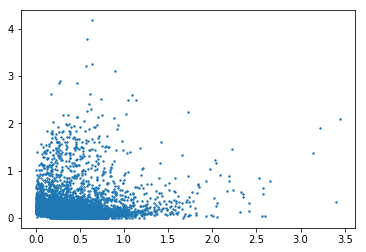

In [21]:
plt.scatter(-np.log10(combinedDEres[0]['pvalue']),-np.log10(combinedDEres[0]['PValue']),s=2)

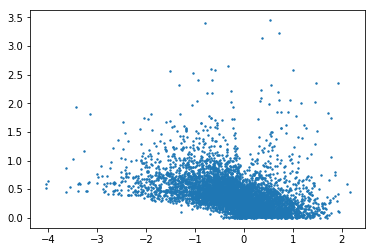

In [24]:
plt.scatter((combinedDEres[0]['norm_logFC']),-np.log10(combinedDEres[0]['pvalue']),s=2)

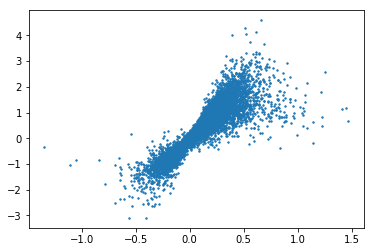

In [28]:
plt.scatter((combinedDEres[0]['scVI_logFC']),combinedDEres[0]['bayes1'],s=2)

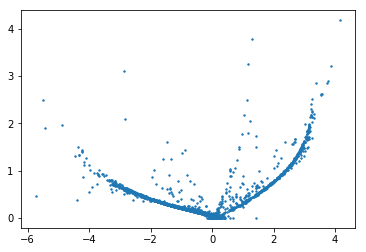

In [25]:
plt.scatter((combinedDEres[0]['logFC']),-np.log10(combinedDEres[0]['PValue']),s=2)

In [34]:
len(celltype)

13

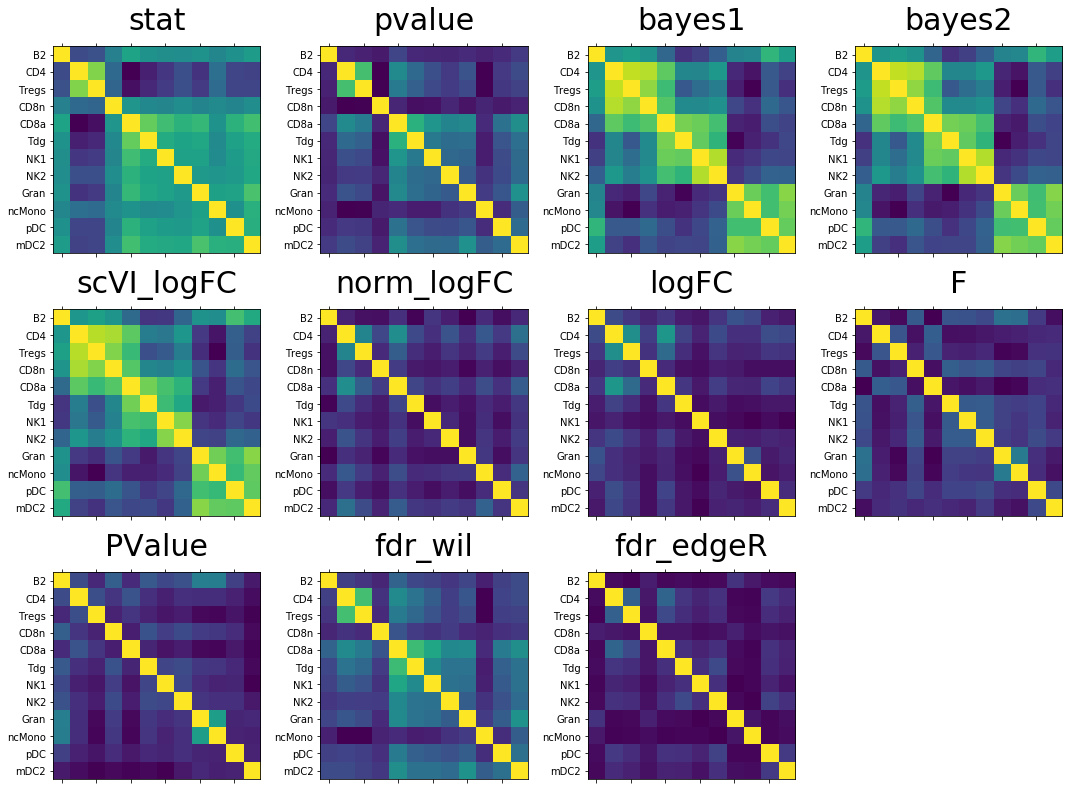

In [68]:
plt.figure(figsize=(15,15))
corr = []
for k, stat in enumerate(['stat','pvalue','bayes1','bayes2','scVI_logFC','norm_logFC','logFC','F','PValue','fdr_wil','fdr_edgeR']):
    df = pd.concat([x[stat] for x in combinedDEres],axis=1)
    df.columns = celltype
    df = df[['B2','CD4','Tregs','CD8n','CD8a','Tdg','NK1','NK2','Gran','ncMono','pDC','mDC2']]
    ax = plt.subplot(4,4,(k+1))
    res = df.corr(method='spearman')
    corr.append(res)
    ax.matshow(res)
    plt.title(stat,fontsize=30)
    plt.xticks(color='w')
    plt.yticks(range(len(df.columns)), df.columns)
    plt.tight_layout()



In [17]:
from pandas import ExcelWriter
import xlsxwriter


writer = pd.ExcelWriter(save_path + 'DE/MSinCSF.xlsx', engine='xlsxwriter')
for i, x in enumerate(celltype):
    combinedDEres[i].to_excel(writer, sheet_name=str(x))
writer.close()


In [18]:
celltype

['B2',
 'CD4',
 'CD8a',
 'CD8n',
 'Gran',
 'NK1',
 'NK2',
 'Tdg',
 'Tregs',
 'mDC1',
 'mDC2',
 'ncMono',
 'pDC']

# GSEA

In [19]:
gmt = ['c7.all.v6.2.symbols.gmt',
       'Hemato.geneset.gmt',
       'cell_cycle_Tirosh.gmt',
       'chenling.gmt',
       'netPath.gmt',
       'codeset.gmt',
       'signatures_NY_private.gmt']
gmt = ['../CSF/signatures/'+x for x in gmt]

In [20]:
def DE_GSEA(filtered,gmt,celltypes,filename):
    gsea_res = []
    for x in filtered:
        if len(x)>0:
            res1 = gp.enrichr(gene_list=list(x.index),
                     gene_sets=['KEGG_2016'],
                     cutoff=0.5                    )
            res2 = gp.enrichr(gene_list=list(x.index),
                             gene_sets=gmt,
                             cutoff=0.5,
                             background=10266)
            res = pd.concat([res1.results,res2.results])
            res = res.sort_values(by='P-value')
            res['cluster'] = celltypes[list(x['clusters'])[0]]
            gsea_res.append(res.loc[res['Adjusted P-value']<0.05])
    gsea_res = pd.concat(gsea_res)
    gsea_res = gsea_res[['Adjusted P-value','Genes','Term','Overlap','cluster']]
    gsea_res.to_csv(filename)
    return(gsea_res)


# upregulated in MS

In [11]:
filtered = [x.loc[(x['fdr_wil']<0.2)&(x['fdr_edgeR']<0.2)& 
                  (x['bayes1']>0.3) &
                  (x['logFC']>0) & (x['norm_logFC']>0)] for x in combinedDEres]

DEgenes = pd.concat(filtered)
geneid, nocc = np.unique(DEgenes.index,return_counts=True)
shared = pd.DataFrame([geneid,nocc],index=['genename','occ']).T
shared = shared.sort_values(by='occ',ascending=False)

DEgenes['clusters'] = np.asarray(celltypes)[np.asarray(DEgenes['clusters']).astype(int)]
DEgenes = DEgenes.sort_index()
DEgenes.to_csv(save_path+'DE/MSinCSF.upregulated.relaxed.csv')

In [12]:
temp1 = filtered[1].index

In [13]:
celltypes[filtered[1]['clusters'][0]]

'CD4'

In [15]:
DEgenes = pd.concat(combinedDEres)

In [16]:
DEgenes.loc[['FGF9']]

,stat,pvalue,bayes1,bayes2,mean1,mean2,nonz1,nonz2,clusters,scVI_logFC,norm_logFC,logFC,logCPM,F,PValue,fdr_wil,fdr_edgeR
FGF9,2091.0,3.962347e-01,-1.036440,1.048081,0.000000,0.000000,0.000000,0.000000,2,-0.261205,NaN,-6.404787e-16,9.259941,0.000000e+00,1.000000,8.617855e-01,1.000000
FGF9,17942943.0,1.285726e-47,-0.096450,0.102565,0.006800,0.005267,0.006600,0.004733,3,0.001185,0.411901,-2.093801e-02,9.306959,7.909865e+00,0.496751,5.215707e-44,0.003034
FGF9,2123009.0,1.646257e-54,-0.271022,0.275454,0.003633,0.003167,0.003633,0.003167,4,-0.109135,0.102772,-3.413690e-02,9.573272,1.715307e+01,0.406734,4.992085e-53,0.940367
FGF9,4752.0,2.840764e-01,-0.254617,0.248470,0.008433,0.033100,0.008433,0.033100,5,-0.050944,-1.378012,-1.808700e-01,9.316629,1.122201e+00,0.619805,8.605562e-01,1.000000
FGF9,8423.0,2.667569e-04,-0.673980,0.666889,0.000000,0.008033,0.000000,0.008033,6,-0.251081,-inf,3.608057e-02,8.743791,-2.701856e-10,1.000000,1.997601e-03,1.000000
FGF9,612.0,3.597280e-02,-1.061882,1.053877,0.000000,0.000000,0.000000,0.000000,10,-0.359144,NaN,8.375398e-17,9.758233,0.000000e+00,1.000000,1.124926e-01,0.843902
FGF9,5086.0,5.862963e-03,-1.054138,1.054791,0.000000,0.000000,0.000000,0.000000,11,-0.400579,NaN,-8.086118e-17,9.550963,0.000000e+00,1.000000,1.867810e-02,0.958387
FGF9,3848.0,7.560464e-05,-1.053421,1.051791,0.014733,0.017700,0.014733,0.017700,13,-0.340010,-0.475336,-3.566869e-02,9.640813,4.936059e-09,0.999944,2.700632e-04,0.997764
FGF9,439950.0,1.941113e-09,-0.360608,0.341351,0.001000,0.003433,0.001000,0.003433,14,-0.103261,-2.008793,1.862381e-01,9.371216,8.884451e+01,0.012365,3.198738e-07,0.250176
FGF9,450.0,6.281455e-01,-1.763820,1.745574,0.000000,0.000000,0.000000,0.000000,17,-0.499133,NaN,2.496805e-16,7.805786,0.000000e+00,1.000000,9.295865e-01,1.000000


In [24]:
%%capture
filtered_GSEA = DE_GSEA(filtered,gmt,celltypes,save_path+'DE/MSinCSF.upregulated.relaxed.GSEA.csv')

In [25]:
filtered = [x.loc[(x['fdr_wil']<0.05)&(x['fdr_edgeR']<0.05)& 
                  (x['bayes1']>0.5) &
                  (x['logFC']<0) & (x['norm_logFC']>0)] for x in combinedDEres]

DEgenes = pd.concat(filtered)
geneid, nocc = np.unique(DEgenes.index,return_counts=True)
shared = pd.DataFrame([geneid,nocc],index=['genename','occ']).T
shared = shared.sort_values(by='occ',ascending=False)

DEgenes['clusters'] = np.asarray(celltypes)[np.asarray(DEgenes['clusters']).astype(int)]
DEgenes = DEgenes.sort_index()
DEgenes.to_csv(save_path+'DE/MSinCSF.upregulated.csv')


In [26]:
%%capture
filtered_GSEA = DE_GSEA(filtered,gmt,celltypes,save_path+'DE/MSinCSF.upregulated.GSEA.csv')

# downregulated in MS

In [27]:

filtered = [x.loc[(x['fdr_wil']<0.2)&(x['fdr_edgeR']<0.2)& 
                  (x['bayes2']>0.3) &
                  (x['logFC']>0) & (x['norm_logFC']<0)] for x in combinedDEres]


DEgenes = pd.concat(filtered)
geneid, nocc = np.unique(DEgenes.index,return_counts=True)
shared = pd.DataFrame([geneid,nocc],index=['genename','occ']).T
shared = shared.sort_values(by='occ',ascending=False)
DEgenes = DEgenes.sort_index()
DEgenes['clusters'] = np.asarray(celltypes)[np.asarray(DEgenes['clusters']).astype(int)]

DEgenes.to_csv(save_path+'DE/MSinCSF.downregulated.relaxed.csv')

In [28]:
temp2= filtered[1].index

In [29]:
celltypes[filtered[1]['clusters'][0]]

'CD4'

In [30]:
%%capture
filtered_GSEA = DE_GSEA(filtered,gmt,celltypes,save_path+'DE/MSinCSF.downregulated.relaxed.GSEA.csv')

In [31]:
filtered = [x.loc[(x['fdr_wil']<0.05)&(x['fdr_edgeR']<0.05)& 
                  (x['bayes2']>0.5) &
                  (x['logFC']>0) & (x['norm_logFC']<0)] for x in combinedDEres]
DEgenes = pd.concat(filtered)
geneid, nocc = np.unique(DEgenes.index,return_counts=True)
shared = pd.DataFrame([geneid,nocc],index=['genename','occ']).T
shared = shared.sort_values(by='occ',ascending=False)
DEgenes = DEgenes.sort_index()
DEgenes['clusters'] = np.asarray(celltypes)[np.asarray(DEgenes['clusters']).astype(int)]
DEgenes.to_csv(save_path+'DE/MSinCSF.downregulated.csv')

In [32]:
%%capture
filtered_GSEA = DE_GSEA(filtered,gmt,celltypes,save_path+'DE/MSinCSF.downregulated.GSEA.csv')

# visualizations

In [33]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt


%matplotlib inline

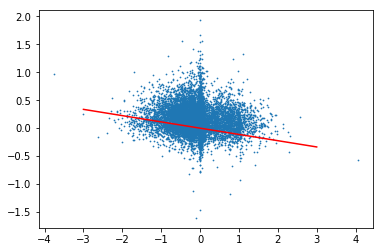

In [34]:
x = combinedDEres[3]['logFC']
y = combinedDEres[3]['scVI_logFC']
xrange = np.max(np.abs(x))
plt.scatter(x,y,s=.5)
cor = np.asarray(pd.concat([x,y],1).corr())[0,1]
plt.plot([-3,3],[-3*cor,3*cor],'r-')